In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('text',usetex=False)

from pathlib import Path
import os,sys
import h5py, json
import sys 
import pickle as pkl
import time

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')  
sys.path.append('../Lib/')
sys.path.append('../Analyses/')
from filters_ag import *

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF
import zone_analyses_session as ZA


In [2]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = oakPaths['Root']/'Clustered'
oakPaths['PreProcessed'] = oakPaths['Root']/'PreProcessed'
oakPaths['Raw'] =oakPaths['Root'] / 'RawData'/'InVivo'
oakPaths['Analyses'] =oakPaths['Root']/'Analyses'

In [3]:
animal = 'Li'
task = 'T3g'
date = '062718'
session = animal+'_'+task+'_'+date

In [5]:
sessionPaths = ZA.getSessionPaths(oakPaths,session)
PosDat = TMF.getBehTrackData(sessionPaths,0)
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sessionPaths,PosDat['t'])
cell_FR, mua_FR = SF.getSessionFR(sessionPaths)
mu=np.mean(cell_FR,1)
sig=np.std(cell_FR,1)

Loading Beh Tracking Data
Complete.
Loading Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [1429]:
def getPosSequence(PosZones,startID,endID):
    nSamps = len(PosZones)
    pos = []
    samp = []
    
    pos.append(PosZones[0])
    samp.append(0)
    for p in np.arange(nSamps-1):
        p0 = PosZones[p]
        p1 = PosZones[p+1]
        if p0!=p1:
            pos.append(p1)
            samp.append(p+1)
    pos = np.array(pos)
    samp = np.array(samp) + startID
    nPos = len(pos)
    dur = np.zeros(nPos,dtype=int)
    for p in np.arange(nPos-1):
        dur[p] = samp[p+1]-samp[p]
    dur[-1] = endID-samp[-1]
        
    return pos, samp, dur

def cmp(a,b):
    return (a>b)-(a<b)

def getTrials(dat,**kwargs):
    nTr = dat.shape[0]
    trials = set(np.arange(1,nTr+1))
    try:
        for k,v in kwargs.items():
            trials = trials & set(np.where(dat[k]==v)[0]+1)
    except:
        print('Invalid Selection {} {}'.format(k,v))
        pass
    return np.sort(np.array(list(trials)))

def zscore(x,mu,sig):
    return (x-mu)/sig

def getFR_TrZone(TrialInfo, FRMat):
    nCells = cell_FR.shape[0]
    TrZnFR = {} # FR for every zone visited in that trial
    OTrZnFR = {} # FR for every zone visited in that trial
    
    for tr in TrialInfo['All']['Trials']:
        nPos = len(TrialInfo['TrSeq']['Pos'][tr])
        trSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['TrSeq']['Samp'][tr][p]
            d=TrialInfo['TrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                trSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        nPos = len(TrialInfo['OffTrSeq']['Pos'][tr])
        otrSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['OffTrSeq']['Samp'][tr][p]
            d=TrialInfo['OffTrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                otrSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        TrZnFR[tr] = trSpPos
        OTrZnFR[tr] = otrSpPos
    return TrZnFR, OTrZnFR

In [1442]:
ValidTraj = {'R_S1':['Home','SegA','Center','SegB','I1','SegC','G1'],
               'R_S2':['Home','SegA','Center','SegB','I1','SegD','G2'],
               'R_L1':['Home','SegA','Center','SegB','I1','SegD','G2','SegD','I1','SegC','G1'],
               'R_L2':['Home','SegA','Center','SegB','I1','SegC','G1','SegC','I1','SegD','G2'],
               'L_S3':['Home','SegA','Center','SegE','I2','SegF','G3'],
               'L_S4':['Home','SegA','Center','SegE','I2','SegG','G4'],
               'L_L3':['Home','SegA','Center','SegE','I2','SegG','G4','SegG','I2','SegF','G3'],
               'L_L4':['Home','SegA','Center','SegE','I2','SegF','G3','SegF','I2','SegG','G4'],
              }
ValidOffTraj = {}
for k,v in ValidTraj.items():
    ValidOffTraj[k] = v[::-1]

# get trial durations and samples
TrialVec = PosDat['EventDat']['TrID']
nTr=TrialVec.max()

startIDs = np.zeros(nTr,dtype=int)
endIDs = np.zeros(nTr,dtype=int)
for tr in np.arange(nTr):
    trIDs = np.where(TrialVec==(tr+1))[0]
    startIDs[tr]=trIDs[0]
    endIDs[tr] = trIDs[-1]

TrialDurs = endIDs-startIDs

OffTrialDurs=np.concatenate((startIDs[1:],[len(PosDat['t'])]))-endIDs
OffTrialVec = np.full_like(TrialVec,0)

for tr in np.arange(nTr):
    idx = np.arange(endIDs[tr],endIDs[tr]+OffTrialDurs[tr])
    OffTrialVec[idx]=tr+1
    
# Pre allocated Trial Info structure.
TrialInfo = {'All':{'Trials':[],'Co':[],'InCo':[]},'L':{'Trials':[],'Co':[],'InCo':[]},
             'R':{'Trials':[],'Co':[],'InCo':[]},'BadTr':[],'Cues':np.full(nTr,''),'Desc':np.full(nTr,''),
             'DurThr':45,'TrDurs':TrialDurs,
             'TrialVec':TrialVec,'TrStSamp':startIDs,'TrEnSamp':endIDs,'TrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'OffTrStSamp':endIDs,'OffTrEnSamp':endIDs+OffTrialDurs,'OffTrDurs':OffTrialDurs,
             'OffTrialVec':OffTrialVec, 'OffTrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'ValidSeqTrials':[],'ValidSeqOffTrials':[],'ValidSeqTrID':[],'ValidSeqOffTrID':[],
             'ValidSeqNames':ValidTraj,'ValidSeqOffNames':ValidOffTraj}

TrialInfo['All']['Trials']=np.arange(nTr)+1
#get separate trials and allocate by correct/incorrect
for tr in TrialInfo['All']['Trials']:
    idx= TrialVec==tr
    for s in ['L','R']:
        c = PosDat['EventDat']['C'+s][idx]        
        d = PosDat['EventDat'][s+'Ds'][idx]
        if np.mean(d)>0.5: # descicion
            TrialInfo['Desc'][tr-1]=s
        if np.mean(c)>0.5: # cue
            TrialInfo[s]['Trials'].append(tr)
            TrialInfo['Cues'][tr-1]=s
            if np.mean(d&c)>0.5: # correct descicion
                TrialInfo[s]['Co'].append(tr)
            else:
                TrialInfo[s]['InCo'].append(tr)
assert set(TrialInfo['R']['Trials']) & set(TrialInfo['L']['Trials']) == set(), 'Trial classified as both left and right.'
assert len(TrialInfo['Cues']) ==len(TrialInfo['Desc']), 'Number of trials mismatch'
assert len(TrialInfo['Cues']) ==nTr, 'Number of trials mismatch'

for trC in ['Co', 'InCo']:
    TrialInfo['All'][trC] = np.sort(TrialInfo['L'][trC]+TrialInfo['R'][trC])

for i in ['All','L','R']:
    for j in ['Trials','Co','InCo']:
        TrialInfo[i]['n'+j]=len(TrialInfo[i][j])
        TrialInfo[i][j]=np.array(TrialInfo[i][j])

# determine if the trials are too long to be included.
TrialInfo['BadTr'] = np.where(TrialInfo['TrDurs']*PosDat['step']>TrialInfo['DurThr'])[0]

# get positions for each trial
for tr in TrialInfo['All']['Trials']:
    
    idx = TrialInfo['TrialVec']==tr
    sID = TrialInfo['TrStSamp'][tr-1]
    eID = TrialInfo['TrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)
    #p,s,d=getPosSequence(p4[idx],sID,eID)
    
    TrialInfo['TrSeq']['Pos'][tr]=p
    TrialInfo['TrSeq']['Samp'][tr]=s
    TrialInfo['TrSeq']['Dur'][tr]=d
    
    idx = TrialInfo['OffTrialVec']==tr
    sID = TrialInfo['OffTrStSamp'][tr-1]
    eID = TrialInfo['OffTrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)    

    TrialInfo['OffTrSeq']['Pos'][tr]=p
    TrialInfo['OffTrSeq']['Samp'][tr]=s
    TrialInfo['OffTrSeq']['Dur'][tr]=d

# determine if the sequence of positions are valid for each trial
TrSeqs = {}
vTr = []
OffTrSeqs = {}
vOTr = []
for tr in TrialInfo['All']['Trials']:
    seq = [TMF.Zones[a] for a in TrialInfo['TrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidTraj.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vTr.append(tr)
            TrSeqs[tr]=vSeqN
            break
    if match==0:
        TrSeqs[tr]=[]
    
    seq =  [TMF.Zones[a] for a in TrialInfo['OffTrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidOffTraj.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vOTr.append(tr)
            OffTrSeqs[tr]=vSeqN
            break
    if match==0:
        OffTrSeqs[tr]=[]
        
TrialInfo['ValidSeqTrials'] = vTr
TrialInfo['ValidSeqOffTrials'] = vOTr
TrialInfo['ValidSeqTrID'] = TrSeqs
TrialInfo['ValidSeqOffTrID'] = OffTrSeqs

conds = ['Cues','Desc','Co','Traj','OTraj','Dur','Good','Short']
TrCondMat = pd.DataFrame(np.full((nTr,len(conds)),np.nan),index=TrialInfo['All']['Trials'],columns=conds)

TrCondMat['Cues'] = TrialInfo['Cues']
TrCondMat['Desc'] = TrialInfo['Desc']
TrCondMat['Dur'] = TrialDurs

TrCondMat['Co'].loc[TrialInfo['All']['Co']]='Co'
TrCondMat['Co'].loc[TrialInfo['All']['InCo']]='InCo'

vseq=TrialInfo['ValidSeqTrials']
TrCondMat['Traj'].loc[vseq]=[TrialInfo['ValidSeqTrID'][s] for s in vseq]

vseq=TrialInfo['ValidSeqOffTrials']
TrCondMat['OTraj'].loc[vseq]=[TrialInfo['ValidSeqOffTrID'][s] for s in vseq]

TrCondMat['Good'] = (~TrCondMat['Traj'].isnull()) & (TrialDurs*PosDat['step']<TrialInfo['DurThr'])

x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
TrCondMat['Short']= x=='S'

x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqOffTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
TrCondMat['OShort']= x=='S'


In [1436]:
x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
x

array(['S', '', 'L', 'L', 'L', 'S', 'S', 'L', 'S', 'L', 'L', 'S', 'L',
       'L', 'L', '', 'L', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S',
       'S', 'L', 'S', 'S', 'L', 'S', 'S', 'S', 'S', 'L', 'L', 'L', '',
       'S', 'L', 'S', 'S', 'L', 'L', 'S', 'S', 'L', 'L', 'S', 'S', 'S',
       'S', 'S', 'L', 'L', 'L', 'L', 'L', 'L', 'S', 'L', 'S', 'L', 'S',
       'S', 'S', '', '', 'S', 'S', 'L', 'S', 'L', 'L', '', 'S', 'S', 'S',
       'L', 'S', 'L', 'S', 'S', 'S', 'L', 'S', 'L', 'S', 'S', 'L', 'L',
       'S', 'S', 'L', 'S', 'S', 'L', 'S', 'S', 'L', 'L', 'L', 'S', 'L',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'S', 'L', 'S', 'S', '', '',
       'L', '', 'L', 'S', 'S', 'L', 'L', 'S', 'L', 'S', 'L', 'S', 'S',
       'S', 'S', '', 'L', 'L', 'L', 'L', '', 'L', 'L', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'L', '', 'S', 'L', 'S', 'L', 'L', 'L', '',
       'L', 'L', 'S', 'L', 'S', 'S', 'S', 'S', 'S', 'S', 'L', 'L', '',
       'S', 'L', 'S', 'L', 'S', '', 'S', 'S', 'L', 'S', 'S

In [9]:
TrInfo_Fn = sessionPaths['Analyses'] / 'TrialInfo.pkl'
with TrInfo_Fn.open(mode='wb') as f:
    pkl.dump(TrialInfo,f,pkl.HIGHEST_PROTOCOL)

In [23]:
a=list(TrSeqs.values())
vTr = np.array(vTr)
apd = pd.Series(a)
print(apd.iloc[vTr-1].value_counts())

a=list(OffTrSeqs.values())
vOTr = np.array(vOTr)
apd = pd.Series(a)
print(apd.iloc[vOTr-1].value_counts())

#apd.iloc[vTr]

L_S3    61
R_S2    48
L_L4    43
R_L1    37
R_S1     5
L_L3     1
dtype: int64
R_S2    45
L_S3    43
L_S4    31
R_S1    29
L_L3     8
R_L1     5
R_L2     1
dtype: int64


In [687]:
TrZn,OTrZn = getFR_TrZone(TrialInfo,cell_FR)

In [1567]:
cell = 15
X=pd.DataFrame(np.full((nTr,TMF.nZones),np.nan),index=TrialInfo['All']['Trials'],columns=TMF.ZonesNames)
Y=pd.DataFrame(np.full((nTr,TMF.nZones),np.nan),index=TrialInfo['All']['Trials'],columns=TMF.ZonesNames)

for tr in TrialInfo['All']['Trials']:
    traj = TrialInfo['ValidSeqTrID'][tr]
    if traj in ValidTrajNames:
        locs=ValidTraj[traj]
        X.loc[tr][locs] = zscore(TrZn[tr][cell],mu[cell],sig[cell])
    traj = TrialInfo['ValidSeqOffTrID'][tr]
    if traj in ValidTrajNames:
        locs=ValidOffTraj[traj]
        Y.loc[tr][locs] = zscore(OTrZn[tr][cell],mu[cell],sig[cell])
Z=X-Y

cellDat = pd.DataFrame()
for traj in ValidTrajNames:
    goal = traj[3]
    if traj[2]=='S':
        nOutPos = 7
    elif traj[2]=='L':
        nOutPos = 11

    outTrials = getTrials(TrCondMat,Good=True,Traj=traj)
    nOutTr = len(outTrials)
    if nOutTr > 1:
        # Valid outbound trials
        outLocs = ValidTraj[traj]
        x = pd.DataFrame(np.zeros((nOutTr,nOutPos)),columns=np.arange(nOutPos))
        cTr = TrCondMat.loc[outTrials]['Co']
        cues = TrCondMat.loc[outTrials]['Cues']
        desc = TrCondMat.loc[outTrials]['Desc']
        cnt = 0
        for tr in outTrials:
            x.iloc[cnt]=X.loc[tr][outLocs].values
            cnt+=1
        
        x = x.melt(var_name='Pos',value_name='zFR')
        x = x.assign(Traj = [traj]*(nOutTr*nOutPos) )
        x = x.assign(IO = ['Out']*(nOutTr*nOutPos) )
        x = x.assign(Goal = [goal]*(nOutTr*nOutPos) )
        x = x.assign(Cue = np.tile(cues,nOutPos) )
        x = x.assign(Desc = np.tile(desc,nOutPos) )
        x = x.assign(trID = np.tile(outTrials, nOutPos).astype(int))
        x = x.assign(Co = np.tile(cTr,nOutPos))
        cellDat = pd.concat([cellDat,x])
        
        # y: subset of outbound trials that are directly 'short' inbound
        # z: difference in the overlapping positions between outbount/inbound
        inTrials = getTrials(TrCondMat,Good=True,Traj=traj,OShort=True)
        nInTr = len(inTrials)
        nInPos = 7
        y = pd.DataFrame(np.zeros((nInTr,nInPos)),columns=np.arange(nInPos))
        z = pd.DataFrame(np.zeros((nInTr,nInPos)),columns=np.arange(nInPos))
        cTr = TrCondMat.loc[inTrials]['Co']
        cues = TrCondMat.loc[inTrials]['Cues']
        desc = TrCondMat.loc[inTrials]['Desc']
        cnt = 0
        for tr in inTrials:
            inLocs = ValidOffTraj[TrCondMat.loc[tr,'OTraj']]
            y.iloc[cnt]=Y.loc[tr][inLocs].values
            z.iloc[cnt]=Z.loc[tr][inLocs].values
            cnt+=1

        y = y.melt(var_name='Pos',value_name='zFR')
        y = y.assign(Traj = [traj]*(nInTr*nInPos) )
        y = y.assign(IO = ['In']*(nInTr*nInPos) )
        y = y.assign(Goal = [goal]*(nInTr*nInPos) )
        y = y.assign(Cue = np.tile(cues, nInPos))
        y = y.assign(Desc = np.tile(desc,nInPos) )
        y = y.assign(trID = np.tile(inTrials, nInPos).astype(int))
        y = y.assign(Co = np.tile(cTr,nInPos))
        cellDat = pd.concat([cellDat,y])

        z = z.melt(var_name='Pos',value_name='zFR')
        z = z.assign(Traj = [traj]*(nInTr*nInPos) )
        z = z.assign(IO = ['O-I']*(nInTr*nInPos) )
        z = z.assign(Goal = [goal]*(nInTr*nInPos) )
        z = z.assign(Cue = np.tile(cues, nInPos))
        z = z.assign(Desc = np.tile(desc,nInPos) )
        z = z.assign(trID = np.tile(inTrials, nInPos).astype(int))
        z = z.assign(Co = np.tile(cTr,nInPos))
        cellDat = pd.concat([cellDat,z])

In [1483]:
set(np.unique(cellDat[cellDat['cue']=='R']['trialID'])) & set(TrialInfo['R']['Trials'])

{1,
 6,
 7,
 9,
 18,
 20,
 23,
 24,
 25,
 26,
 31,
 32,
 34,
 36,
 38,
 41,
 43,
 48,
 50,
 53,
 54,
 57,
 58,
 60,
 61,
 63,
 65,
 66,
 67,
 71,
 72,
 73,
 79,
 81,
 82,
 86,
 87,
 88,
 92,
 94,
 95,
 98,
 100,
 104,
 107,
 108,
 109,
 111,
 126,
 129,
 130,
 137,
 143,
 144,
 145,
 150,
 151,
 152,
 154,
 155,
 156,
 162,
 163,
 165,
 167,
 170,
 171,
 174,
 177,
 178,
 181,
 185,
 187,
 188,
 191,
 192,
 193,
 194,
 196,
 197,
 199,
 203,
 205,
 207}

In [1484]:
len(getTrials(TrCondMat,Good=True,Co='InCo')),len(getTrials(TrCondMat,Good=True))

(33, 194)

In [1517]:
TrCondMat

,Cues,Desc,Co,Traj,OTraj,Dur,Good,Short,OShort
1,R,R,Co,R_S1,R_L1,632,True,True,False
2,R,L,InCo,NaN,NaN,404,False,False,False
3,L,R,InCo,R_L1,R_S1,1567,True,False,True
4,L,L,Co,L_L4,L_S4,1234,True,False,True
5,L,R,InCo,R_L1,NaN,630,True,False,False
6,R,R,Co,R_S2,R_S2,520,True,True,True
7,R,L,InCo,L_S3,NaN,400,True,True,False
8,L,R,InCo,R_L1,NaN,655,True,False,False
9,R,L,InCo,L_S3,NaN,568,True,True,False
10,L,L,Co,L_L4,L_S4,571,True,False,True


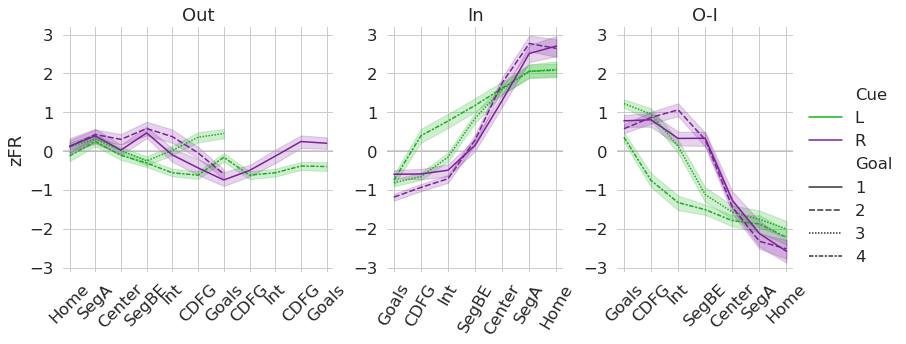

In [1568]:
sns.set()
sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={ 
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})
#,rc={'grid.color':'0.1','axes.labelcolor':'1'})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
pal = sns.xkcd_palette(['green','purple'])

f,ax = plt.subplots(1,3, figsize=(15,4))
yPos = 0.04
w = 0.25
ratio = 7.5/11.5 
hsp = 0.05
W = [w,w*ratio,w*ratio]
xPos = [hsp,2*hsp+W[0],3*hsp+W[1]+W[0]]
H = 0.85
xlims = [[-0.25,10.25],[-0.25,6.25],[-0.25,6.25]]
for i in np.arange(3):
    ax[i].set_position([xPos[i],yPos,W[i],H])
    ax[i].set_xlim(xlims[i])
    ax[i].axhline(color=[0.7,0.7,0.7],alpha=0.7)

xPosLabels = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals'] 

xPosLabels2 = ['Home','SegA','Center','SegBE','Int','CDFG','Goals'][::-1]
with sns.color_palette(pal):
    subset = (cellDat['IO']=='Out') & (cellDat['Co']=='Co')
    ax[0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],ax=ax[0],legend=False,hue_order=['L','R'])
    ax[0].set_xticks(np.arange(11))

    ax[0].tick_params(axis='x', rotation=45)
    ax[0].set_xticklabels(xPosLabels)
    ax[0].set_xlabel('')
    ax[0].set_title('Out')

    subset = (cellDat['IO']=='In') & (cellDat['Co']=='Co')
    ax[1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],ax=ax[1],legend=False,hue_order=['L','R'])
    ax[1].set_xticks(np.arange(7))
    ax[1].tick_params(axis='x', rotation=60)
    ax[1].set_xticklabels(xPosLabels2)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].set_title('In')

    subset = (cellDat['IO']=='O-I') & (cellDat['Co']=='Co')
    ax[2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],ax=ax[2],legend='brief',hue_order=['L','R'])
    ax[2].set_xticks(np.arange(7))
    ax[2].tick_params(axis='x', rotation=45)
    ax[2].set_xticklabels(xPosLabels2)
    ax[2].set_xlabel('')
    ax[2].set_ylabel('')
    ax[2].set_title('O-I')

    lims = np.zeros((3,2))
    for i in np.arange(3):
        lims[i]=np.array(ax[i].get_ylim())
    minY = np.floor(np.min(lims[:,0])*20)/20
    maxY = np.ceil(np.max(lims[:,1]*20))/20

    for i in np.arange(3):
        ax[i].set_ylim([minY,maxY])
    l =ax[2].get_legend()
    #l.set_bbox_to_anchor=(0, 0,0.3,1)
    plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False)
    l.set_frame_on(False)
    #l.set_visible(False)

Text(0.5, 0, 'Direction')

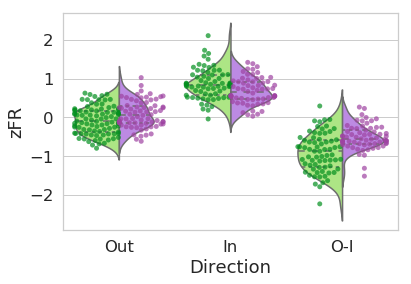

In [1572]:
sns.set(style="whitegrid",font_scale=1.5)
pal = sns.xkcd_palette(['spring green','light purple'])
subset = cellDat['Co']=='Co'
dat = cellDat[subset].groupby(['trID','IO','Cue']).mean()
dat = dat.reset_index()
with sns.color_palette(pal):
    ax=sns.violinplot(y='zFR',x='IO',hue='Cue',data=dat,split=True,scale='count',inner='quartile',hue_order=['L','R'],saturation=0.7)
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax=sns.swarmplot(y='zFR',x='IO',hue='Cue',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,edgecolor='gray')
l=ax.get_legend()
l.set_visible(False)
ax.set_xlabel('Direction')

In [1507]:
subset = cellDat['Co']=='Co'
dat = cellDat[subset].groupby(['trID','IO','Cue']).mean()
dat = dat.reset_index()
dat

,trID,IO,Cue,Pos,zFR
0,1,Out,R,3,0.716570
1,4,In,L,3,1.022205
2,4,O-I,L,3,-0.902246
3,4,Out,L,5,0.119945
4,6,In,R,3,1.324260
5,6,O-I,R,3,-0.243257
6,6,Out,R,3,1.081003
7,10,In,L,3,1.197638
8,10,O-I,L,3,-1.275152
9,10,Out,L,5,0.114758


Text(0.5, 0, 'Decision')

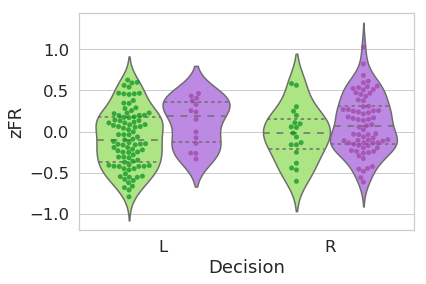

In [1581]:
sns.set(style="whitegrid",font_scale=1.5)
pal = sns.xkcd_palette(['spring green','light purple'])
subset= cellDat['IO']=='Out'
dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
dat = dat.reset_index()

with sns.color_palette(pal):
    ax=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=False,scale='width',inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.7)
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax=sns.swarmplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],hue_order=['L','R'],alpha=0.7,edgecolor='gray')
l=ax.get_legend()
l.set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')
ax.set_xlabel('Decision')

In [1580]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

subset = ~(cellDat['IO']=='O-I')
dat = cellDat[subset]
dat['Pos'] = dat['Pos'].astype('category')
md = smf.mixedlm("zFR ~ Pos+IO+Co*Cue", data=dat,groups=dat["trID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,dat['zFR'])**2)[0,1]))
mdf.wald_test_terms()

/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   zFR       
No. Observations:    2672      Method:               REML      
No. Groups:          193       Scale:                0.6841    
Min. group size:     7         Likelihood:           -3350.1257
Max. group size:     18        Converged:            No        
Mean group size:     13.8                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.061    0.056   1.098 0.272 -0.048  0.170
Pos[T.1]             0.345    0.064   5.411 0.000  0.220  0.470
Pos[T.2]             0.305    0.064   4.777 0.000  0.180  0.430
Pos[T.3]             0.656    0.064  10.276 0.000  0.531  0.781
Pos[T.4]             0.991    0.064  15.536 0.000  0.866  1.116
Pos[T.5]             1.276    0.064  19.992 0.000  1.

/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.stats.contrast.WaldTestResults'>
                 chi2                   P>chi2  df constraint
Intercept    1.204866       0.2723511953305796              1
Pos        758.622274  1.6129812610733004e-156             10
IO         438.175311    2.701287082038924e-97              1
Co           0.153595       0.6951236459812216              1
Cue          0.789357       0.3742947000584328              1
Co:Cue       0.096927       0.7555495272333901              1

In [1600]:
subset = (cellDat['IO']=='O-I')
dat = cellDat[subset]
dat['Pos'] = dat['Pos'].astype('category')
md = smf.mixedlm("zFR ~ Pos+Co*Cue", data=dat,groups=dat["trID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,dat['zFR'])**2)[0,1]))
print(mdf.wald_test_terms())

sns.set()
dat2 = dat.assign(fit = mdf.fittedvalues)
sns.scatterplot(x='zFR',y='fit',hue='Cue',size='Goal',data=dat2,alpha=0.4)

/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   zFR       
No. Observations:    1001      Method:               REML      
No. Groups:          143       Scale:                0.4851    
Min. group size:     7         Likelihood:           -1134.8509
Max. group size:     7         Converged:            Yes       
Mean group size:     7.0                                       
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.522    0.074   7.099 0.000  0.378  0.667
Pos[T.1]            -0.216    0.082  -2.616 0.009 -0.377 -0.054
Pos[T.2]            -0.615    0.082  -7.468 0.000 -0.777 -0.454
Pos[T.3]            -1.242    0.082 -15.077 0.000 -1.403 -1.080
Pos[T.4]            -2.246    0.082 -27.272 0.000 -2.408 -2.085
Pos[T.5]            -2.749    0.082 -33.369 0.000 -2.

AttributeError: 'str' object has no attribute 'view'

In [1602]:
dat2

,Pos,zFR,Traj,IO,Goal,Cue,Desc,trID,Co,fit
0,0,0.321431,R_S2,O-I,2,R,R,6,Co,0.320774
1,0,0.361376,R_S2,O-I,2,L,R,12,InCo,0.820699
2,0,0.426337,R_S2,O-I,2,R,R,18,Co,1.185681
3,0,0.609062,R_S2,O-I,2,R,R,20,Co,0.832152
4,0,0.434584,R_S2,O-I,2,R,R,23,Co,0.834735
5,0,1.016033,R_S2,O-I,2,R,R,25,Co,1.073804
6,0,0.504667,R_S2,O-I,2,R,R,26,Co,0.941706
7,0,0.436442,R_S2,O-I,2,R,R,32,Co,0.824051
8,0,0.561065,R_S2,O-I,2,R,R,43,Co,1.226025
9,0,0.290260,R_S2,O-I,2,R,R,50,Co,0.846277


0      0.320774
1      0.820699
2      1.185681
3      0.832152
4      0.834735
5      1.073804
6      0.941706
7      0.824051
8      1.226025
9      0.846277
10     0.871878
11     0.785424
12     1.104138
13     0.866437
14     1.059822
15     0.967143
16     1.094436
17     0.717915
18     1.034123
19     0.919787
20     1.077384
21     0.786184
22     1.176499
23     0.910678
24     0.750542
25     1.139187
26     0.762668
27     0.926494
28     0.865602
29     0.854952
         ...   
187   -2.746167
188   -2.534662
189   -2.614816
190   -2.476210
191   -2.684738
192   -2.551196
193   -2.781299
194   -2.466407
195   -2.656747
196   -2.739530
197   -2.548088
198   -2.807012
199   -2.626474
200   -2.686921
201   -2.805732
202   -2.553639
203   -2.734384
204   -2.917830
205   -2.497459
206   -2.233700
207   -2.723058
208   -2.864008
209   -2.738572
210   -2.797291
211   -2.381559
212   -2.537297
213   -3.223500
214   -2.602895
215   -2.959224
216   -2.637184
Length: 1001, dtype: flo

In [380]:
TrSeqIDs = {}
OffTrSeqIDs = {}
for k in ValidTrSeqs.keys():
    TrSeqIDs[k] = []
    OffTrSeqIDs[k] = []
    
for k,v in TrSeqs.items():
    if len(v)>0:
        TrSeqIDs[v].append(k)

for k,v in OffTrSeqs.items():
    if len(v)>0:
        OffTrSeqIDs[v].append(k)
        
for k,v in TrSeqIDs.items():
    TrSeqIDs[k]=np.array(v)
for k,v in OffTrSeqIDs.items():
    OffTrSeqIDs[k]=np.array(v)

In [224]:
ZoneN = {}
for n,z in TMF.Zones.items():
    ZoneN[z]=n

ValidTrSeqN = {}
for k,v in ValidTrSeqs.items():
    ValidTrSeqN[k] = [ZoneN[z] for z in ValidTrSeqs[k]]

In [259]:
print(list(TrialInfo['ValidSeqTrID'].values())[:10])
print(list(TrialInfo['ValidSeqOffTrID'].values())[:10])

['R_S1', [], 'R_L1', 'L_L4', 'R_L1', 'R_S2', 'L_S3', 'R_L1', 'L_S3', 'L_L4']
['R_L1', [], 'R_S1', 'L_S4', [], 'R_S2', [], [], [], 'L_S4']


In [807]:
D = pd.DataFrame()
Dout = {}
Din = {}
for k in ValidTrSeqs.keys():
    nPos = len(ValidTrSeqs[k])
    nSeqTr = len(TrSeqIDs[k])
    
    if nSeqTr>0:
        mat = np.zeros((nSeqTr,nPos))
        cTr = np.zeros(nSeqTr)
            
        cnt =0
        for i in TrSeqIDs[k]:
            cTr[cnt] = i in TrialInfo['All']['Co']
            mat[cnt]= TrZnFR[i]
            cnt+=1

        d = pd.DataFrame(mat,columns=ValidTrSeqs[k])
        d = d.melt(var_name='Pos',value_name = 'FR') 
        d = d.assign(io = ['out']*(nSeqTr*nPos))
        d = d.assign(corr = np.tile(cTr,nPos))
        d = d.assign(PosN = np.repeat(ValidTrSeqN[k],nSeqTr))
        d = d.assign(trialID = np.tile(TrSeqIDs[k], nPos).astype(int))
        d = d.assign(traj = [k]*(nSeqTr*nPos))
        D = pd.concat([D,d])
        
    Dout[k]=mat
    nSeqTr = len(OffTrSeqIDs[k])
    if nSeqTr>0:
        mat = np.zeros((nSeqTr,nPos))
        cTr = np.zeros(nSeqTr)
        cnt =0
        for i in OffTrSeqIDs[k]:
            cTr[cnt] = i in TrialInfo['All']['Co']
            mat[cnt]= OffTrZnFR[i]
            cnt+=1

        d2 = pd.DataFrame(mat,columns=ValidTrSeqs[k])
        d2 = d2.melt(var_name='Pos',value_name = 'FR')
        d2 = d2.assign(io = ['in']*(nSeqTr*nPos))
        d2 = d2.assign(corr = np.tile(cTr,nPos))
        d2 = d2.assign(PosN = np.repeat(ValidTrSeqN[k][::-1],nSeqTr))
        d2 = d2.assign(trialID = np.tile(OffTrSeqIDs[k], nPos).astype(int))
        d2 = d2.assign(traj = [k]*(nSeqTr*nPos))

        D = pd.concat([D,d2])
    
    Din[k]=mat
#     f,ax=plt.subplots(1, figsize=(8,5))
#     sns.violinplot(x='Pos',y='FR',hue='io',data=d3,cut=0,inner=None,ax=ax)
#     sns.swarmplot(x='Pos',y='FR',hue='io',data=d3,dodge=True,size=3,color='w',ax=ax)

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[:2], labels[:2])
#     plt.grid()
    #f.savefig(('/mnt/c/Users/alexg8/Desktop/io_traj_{}_cell_{}.pdf').format(k,cell),dpi=500, bbox_inches='tight',pad_inches=0.2)
    #plt.close(f)

In [808]:
DoutM = {}
for k in Dout.keys():
    DoutM[k] = zMat(Dout[k],mu[cell],sig[cell])


In [382]:
TrialInfo['Cues']=='R'

array([ True,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True, False, False,  True, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True, False,  True,  True, False, False,  True, False,
        True, False, False, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False,

IndexError: arrays used as indices must be of integer (or boolean) type

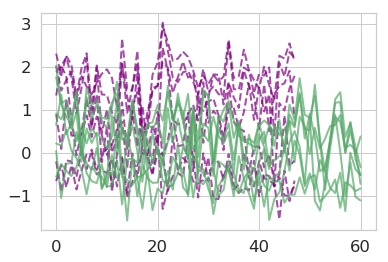

In [809]:
for k in Dout.keys():
    trials = TrSeqIDs[k]
    cues = TrialInfo['Cues'][trials]
    if k[2]=='S' and len(Dout[k])>10:
        if k[0]=='L':
            col = 'g'
        else:
            col = 'purple'

        if k[3] in ['1','3']:
            st = '-'
        else:
            st = '--'
        plt.plot(DoutM[k],label=k, alpha=0.7, linewidth=2, color=col,linestyle=st)
plt.legend()

In [810]:
Dout

{'R_S1': array([[24.71528846, 41.20146341, 28.45011765, 46.33487179, 49.161     ,
         40.82782609, 35.07428571],
        [25.59626016, 37.87777778, 29.0254902 , 35.19939394, 38.076     ,
         36.69375   , 33.25571429],
        [35.15369828, 26.52028169, 23.53361111, 43.85884615, 43.45866667,
         39.53416667, 37.20933333],
        [20.05531034, 29.77121951, 27.22128205, 52.44888889, 53.11      ,
         43.45935484, 37.58222222],
        [33.71375   , 41.80071429, 28.29018868, 35.19409091, 34.81692308,
         31.91826087, 30.88235294]]),
 'R_S2': array([[25.24536842, 39.596875  , 29.4984    , 50.02410256, 52.66      ,
         48.735     , 43.642     ],
        [28.66661765, 32.169375  , 22.933125  , 44.71555556, 47.994     ,
         50.00428571, 50.12857143],
        [23.89378378, 42.76967742, 29.72213115, 46.97407407, 52.16      ,
         51.90555556, 47.67454545],
        [28.67197531, 35.043125  , 29.45140741, 48.75684211, 50.28571429,
         47.65428571, 38.68 

In [378]:
TrialInfo['Cues'][TrSeqIDs[k]]

array(['L', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L',
       'R', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'L', 'L',
       'L', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'L', 'R', 'L',
       'R', 'R', 'R', 'L'], dtype='<U1')

'L'

In [287]:
def zMat(mat,mu,sig):
    return np.mean((mat-mu)/sig,0)

In [281]:

sig

array([ 0.68423244,  1.16399611,  4.0475013 ,  6.6048773 ,  8.26262397,
        7.53833364,  5.40259314,  9.02478519,  7.89578605,  6.53334697,
        9.26563681,  8.80866298,  1.44360144,  6.51492947, 17.10743783,
       15.05154849])

In [233]:
D[(D['Pos']=='SegA') & (D['corr']==1)].mean(),D[(D['Pos']=='SegA') & (D['corr']==0)].mean() 

(FR          37.850144
 corr         1.000000
 PosN         4.774086
 trialID    108.475083
 dtype: float64, FR         37.406553
 corr        0.000000
 PosN        3.821429
 trialID    99.000000
 dtype: float64)

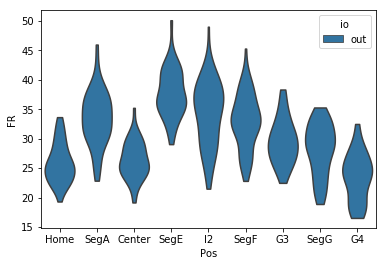

In [738]:
sns.violinplot(x='Pos',y='FR',hue='io',data=d3,cut=0,inner=None)
#f,ax=plt.subplots(1, figsize=(10,5))

#g = sns.FacetGrid(D,col='io',hue='corr',height=6)
#g.map(sns.violinplot,'Pos','FR',cut=0)
#g = sns.catplot(x='Pos',y='FR',hue='io',col='corr',data=D,kind='swarm',dodge=True)

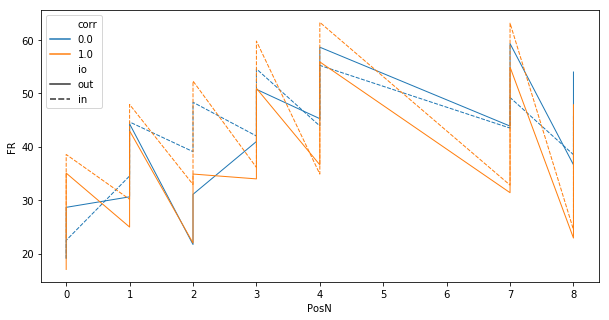

In [243]:
f,ax=plt.subplots(1, figsize=(10,5))
sns.lineplot(x='PosN',y='FR',hue='corr',style='io',data=D[D['traj']=='R_S2'],estimator=None,lw=1)

In [245]:
D[D['traj']=='R_S2']

,Pos,FR,io,corr,PosN,trialID,traj
0,Home,25.245368,out,1.0,0,6,R_S2
1,Home,28.666618,out,0.0,0,12,R_S2
2,Home,23.893784,out,1.0,0,18,R_S2
3,Home,28.671975,out,1.0,0,20,R_S2
4,Home,23.450069,out,1.0,0,23,R_S2
5,Home,27.426531,out,1.0,0,25,R_S2
6,Home,31.102937,out,1.0,0,26,R_S2
7,Home,31.118689,out,1.0,0,32,R_S2
8,Home,26.679535,out,0.0,0,33,R_S2
9,Home,27.603303,out,1.0,0,43,R_S2


In [161]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("FR ~ corr+Pos*io+traj", data=D,groups=D["trialID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,D['FR'])**2)[0,1]))

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     FR        
No. Observations:     2879        Method:                 REML      
No. Groups:           200         Scale:                  24.3439   
Min. group size:      7           Likelihood:             -8756.1639
Max. group size:      22          Converged:              Yes       
Mean group size:      14.4                                          
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              39.743    0.836  47.521 0.000  38.103  41.382
Pos[T.G1]             -16.371    0.965 -16.960 0.000 -18.263 -14.479
Pos[T.G2]             -14.295    0.821 -17.405 0.000 -15.905 -12.685
Pos[T.G3]             -11.163    0.819 -13.632 0.000 -12.768  -9.558
Pos[T.G4]              -9.018    0.935  -9.643 0.0

In [140]:
md = smf.mixedlm("FR ~ 0+Pos+io+traj", data=D,groups=D["trialID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,D['FR'])**2)[0,1]))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: FR        
No. Observations: 2879    Method:             REML      
No. Groups:       200     Scale:              34.6738   
Min. group size:  7       Likelihood:         -9250.5466
Max. group size:  22      Converged:          Yes       
Mean group size:  14.4                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Pos[Center]  33.896    0.839  40.396 0.000 32.251 35.540
Pos[G1]      29.274    1.093  26.789 0.000 27.132 31.416
Pos[G2]      34.662    0.985  35.188 0.000 32.731 36.592
Pos[G3]      30.800    0.895  34.417 0.000 29.046 32.554
Pos[G4]      28.839    0.984  29.312 0.000 26.911 30.768
Pos[Home]    26.775    0.839  31.910 0.000 25.130 28.420
Pos[I1]      42.743    0.934  45.752 0.000 40.912 44.574
Pos[I2]      39.866    0.837  47.617 0.00

In [154]:
mdf.t_test_pairwise("Pos")

ValueError: r_matrix for t-test should have 23 columns

In [199]:
a=list(TrSeqs.values())
vTr = np.array(vTr)
apd = pd.Series(a)
apd.iloc[vTr-1].value_counts()
#apd.iloc[vTr]
#pd.Series(a).value_counts().plot('bar')

L_S3    61
R_S2    48
L_L4    43
R_L1    37
R_S1     5
L_L3     1
dtype: int64

In [257]:
Y

{'R_S1': [1, 52, 168, 180, 210],
 'R_S2': [6,
  12,
  18,
  20,
  23,
  25,
  26,
  32,
  33,
  43,
  50,
  54,
  61,
  63,
  65,
  66,
  71,
  73,
  79,
  81,
  87,
  93,
  99,
  107,
  108,
  109,
  111,
  129,
  132,
  143,
  145,
  150,
  154,
  156,
  163,
  165,
  166,
  170,
  174,
  181,
  185,
  188,
  191,
  192,
  194,
  197,
  199,
  205],
 'L_S3': [7,
  9,
  21,
  24,
  27,
  29,
  30,
  34,
  35,
  40,
  42,
  46,
  47,
  51,
  53,
  67,
  70,
  77,
  78,
  83,
  84,
  85,
  89,
  90,
  94,
  96,
  97,
  100,
  104,
  106,
  110,
  112,
  114,
  116,
  117,
  123,
  124,
  127,
  131,
  133,
  134,
  144,
  146,
  147,
  148,
  149,
  151,
  167,
  169,
  176,
  178,
  183,
  184,
  186,
  189,
  193,
  200,
  201,
  202,
  204,
  209],
 'L_S4': [],
 'R_L1': [3,
  5,
  8,
  22,
  31,
  36,
  38,
  41,
  44,
  48,
  57,
  58,
  60,
  72,
  82,
  86,
  88,
  92,
  95,
  98,
  101,
  115,
  126,
  130,
  137,
  152,
  155,
  161,
  162,
  171,
  172,
  177,
  187,
  195,
  1